# Market Impact Parameter Calibration

## Objective
Calibrate the Almgren-Chriss power-law model parameters using order book data:

**Parameters to estimate:**
- **ψ** (psi): Proportional costs (spread + fees)
- **k**: Permanent impact coefficient (Kyle's lambda)
- **η** (eta): Execution cost coefficient  
- **φ** (phi): Power-law exponent

**Model:**
$$
L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho|
$$

where $\rho = v/V$ is the participation rate.

---

## Methodology

1. **ψ estimation**: Median bid-ask spread
2. **k estimation**: Linear regression (Kyle's lambda)
3. **η, φ estimation**: Non-linear curve fitting

---

# Setup

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import linregress
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Graphics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Imports successful")

✅ Imports successful


---

# Load Order Book Data

In [2]:
import json
import pandas as pd
from datetime import datetime
import s3fs

# Configuration
BUCKET = 'gmarguier'
S3_PREFIX_RAW = f"{BUCKET}/market-impact-data/orderbook-data/raw/"

# S3 connection
try:
    s3 = s3fs.S3FileSystem(
        client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'}
    )
    s3.ls(BUCKET)
    print('✅ S3 connection successful')
except Exception as e:
    print(f'⚠️ S3 connection failed: {e}')
    raise e


# ----------------------------------------------------
# LOAD ALL ORDERBOOK FILES FROM S3 (NO LOCAL FILES)
# ----------------------------------------------------

print("📡 Listing ALL orderbook snapshot files from S3...")
raw_files = [f for f in s3.ls(S3_PREFIX_RAW) if f.endswith(".json")]

if len(raw_files) == 0:
    raise ValueError("❌ No orderbook snapshot files found in S3")

print(f"   📁 {len(raw_files)} files found")

all_snapshots = []

print("\n⬇️ Streaming orderbook snapshots from S3...")
for i, raw_file in enumerate(sorted(raw_files)):
    print(f"   📥 ({i+1}/{len(raw_files)}) {raw_file}")

    # Direct streaming read (no tmp file)
    with s3.open(raw_file, "r") as f:
        snapshots = json.load(f)

    all_snapshots.extend(snapshots)

print(f"\n✅ Loaded a TOTAL of {len(all_snapshots)} snapshots from all files.")
print("\n🚀 Orderbook data successfully loaded from S3 — ready for calibration.")

✅ S3 connection successful
📡 Listing ALL orderbook snapshot files from S3...
   📁 1 files found

⬇️ Streaming orderbook snapshots from S3...
   📥 (1/1) gmarguier/market-impact-data/orderbook-data/raw/BTCUSDT_orderbook.json

✅ Loaded a TOTAL of 30 snapshots from all files.

🚀 Orderbook data successfully loaded from S3 — ready for calibration.


In [3]:
# Load historical daily volume for participation rate calculation
SYMBOL = snapshots[0]['symbol']

try:
    df_params = pd.read_parquet('data/processed/market_parameters.parquet')
    params = df_params[df_params['symbol'] == SYMBOL].iloc[0]
    DAILY_VOLUME = params['volume_per_day']
    print(f"✅ Daily volume from historical data: {DAILY_VOLUME:,.0f} units/day")
except Exception as e:
    print(f"⚠️ Could not load historical volume: {e}")
    DAILY_VOLUME = 25000  # Default for BTCUSDT
    print(f"   Using default estimate: {DAILY_VOLUME:,.0f} units/day")

✅ Daily volume from historical data: 26,163 units/day


---

# 1. Estimate ψ (Proportional Costs)

📊 Estimating ψ (proportional costs)...

Quoted spread statistics (best bid/ask):
   Median: 0.00000011 (0.0011 bps)
   Mean:   0.00000011 (0.0011 bps)

Effective spread statistics (for 5.0 BTC round trip):
   Median: 0.000042 (0.42 bps)
   Mean:   0.000049 (0.49 bps)
   Std:    0.000023 (0.23 bps)
   Min:    0.000015 (0.15 bps)
   Max:    0.000106 (1.06 bps)

✅ ψ = 0.000042 (0.42 bps)
   (Using effective spread for realistic trading costs)


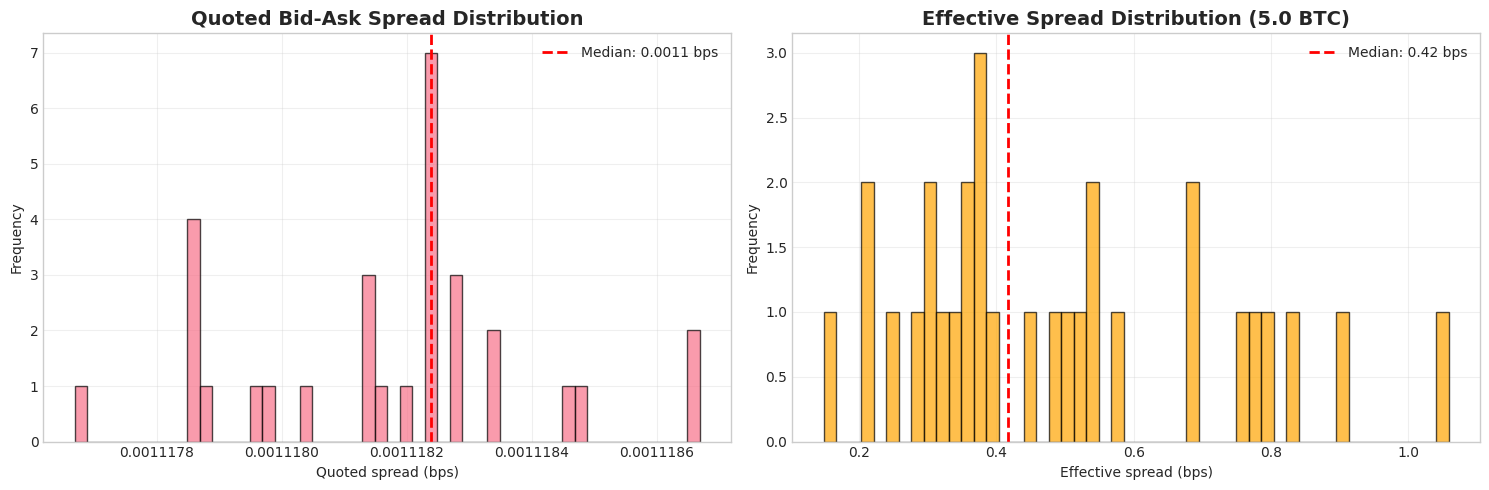

In [4]:
print("📊 Estimating ψ (proportional costs)...\n")


# --------- CALIBRATION PARAMETERS ---------
CALIBRATION_HORIZON_MINUTES = 1        # <-- choisis ton horizon ici (1, 2, 5, etc.)
CALIBRATION_HORIZON_SECONDS = CALIBRATION_HORIZON_MINUTES * 60


spreads = []
effective_spreads = []

# Reference trade size for effective spread
# Note: 0.1 BTC is too small (executes at best price only)
# Using 5.0 BTC to capture realistic execution costs
REFERENCE_SIZE = 5.0

for snapshot in snapshots:
    bids = np.array(snapshot['bids'], dtype=float)
    asks = np.array(snapshot['asks'], dtype=float)
    
    if len(bids) > 0 and len(asks) > 0:
        best_bid = bids[0, 0]
        best_ask = asks[0, 0]
        mid_price = (best_bid + best_ask) / 2
        
        # 1. Quoted spread (at best bid/ask)
        spread_prop = (best_ask - best_bid) / mid_price
        spreads.append(spread_prop)
        
        # 2. Effective spread (simulate market order round-trip)
        # Buy REFERENCE_SIZE BTC
        remaining = REFERENCE_SIZE
        total_cost = 0.0
        
        for price, quantity in asks:
            if remaining <= 0:
                break
            executed = min(remaining, quantity)
            total_cost += executed * price
            remaining -= executed
        
        if remaining <= 0:  # Sufficient liquidity
            avg_buy_price = total_cost / REFERENCE_SIZE
            
            # Sell REFERENCE_SIZE BTC
            remaining = REFERENCE_SIZE
            total_revenue = 0.0
            
            for price, quantity in bids:
                if remaining <= 0:
                    break
                executed = min(remaining, quantity)
                total_revenue += executed * price
                remaining -= executed
            
            if remaining <= 0:  # Sufficient liquidity
                avg_sell_price = total_revenue / REFERENCE_SIZE
                
                # Effective spread = (buy price - sell price) / 2 / mid
                effective_spread = (avg_buy_price - avg_sell_price) / 2 / mid_price
                effective_spreads.append(effective_spread)

# Use EFFECTIVE spread (more realistic for trading costs)
psi_estimated = np.median(effective_spreads) if len(effective_spreads) > 0 else np.median(spreads)

print(f"Quoted spread statistics (best bid/ask):")
print(f"   Median: {np.median(spreads):.8f} ({np.median(spreads)*10000:.4f} bps)")
print(f"   Mean:   {np.mean(spreads):.8f} ({np.mean(spreads)*10000:.4f} bps)")

print(f"\nEffective spread statistics (for {REFERENCE_SIZE} BTC round trip):")
print(f"   Median: {np.median(effective_spreads):.6f} ({np.median(effective_spreads)*10000:.2f} bps)")
print(f"   Mean:   {np.mean(effective_spreads):.6f} ({np.mean(effective_spreads)*10000:.2f} bps)")
print(f"   Std:    {np.std(effective_spreads):.6f} ({np.std(effective_spreads)*10000:.2f} bps)")
print(f"   Min:    {np.min(effective_spreads):.6f} ({np.min(effective_spreads)*10000:.2f} bps)")
print(f"   Max:    {np.max(effective_spreads):.6f} ({np.max(effective_spreads)*10000:.2f} bps)")

print(f"\n✅ ψ = {psi_estimated:.6f} ({psi_estimated*10000:.2f} bps)")
print(f"   (Using effective spread for realistic trading costs)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Quoted spread
ax = axes[0]
ax.hist(np.array(spreads) * 10000, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(np.median(spreads) * 10000, color='red', linestyle='--', linewidth=2,
            label=f'Median: {np.median(spreads)*10000:.4f} bps')
ax.set_xlabel('Quoted spread (bps)')
ax.set_ylabel('Frequency')
ax.set_title('Quoted Bid-Ask Spread Distribution', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Effective spread
ax = axes[1]
ax.hist(np.array(effective_spreads) * 10000, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax.axvline(psi_estimated * 10000, color='red', linestyle='--', linewidth=2,
            label=f'Median: {psi_estimated*10000:.2f} bps')
ax.set_xlabel('Effective spread (bps)')
ax.set_ylabel('Frequency')
ax.set_title(f'Effective Spread Distribution ({REFERENCE_SIZE} BTC)', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# 2. Estimate k (Kyle's Lambda / Permanent Impact)

📈 Estimating k (Kyle's lambda)...

Simulating market orders at different sizes...

✅ Collected 588 impact measurements
   Samples per size: 29

Regression results:
   Slope (λ):  0.00000855
   Intercept:  -0.00000602
   R²:         0.9947
   p-value:    0.000000

✅ k = 0.00000855
   For 100 units: impact ≈ 8.55 bps


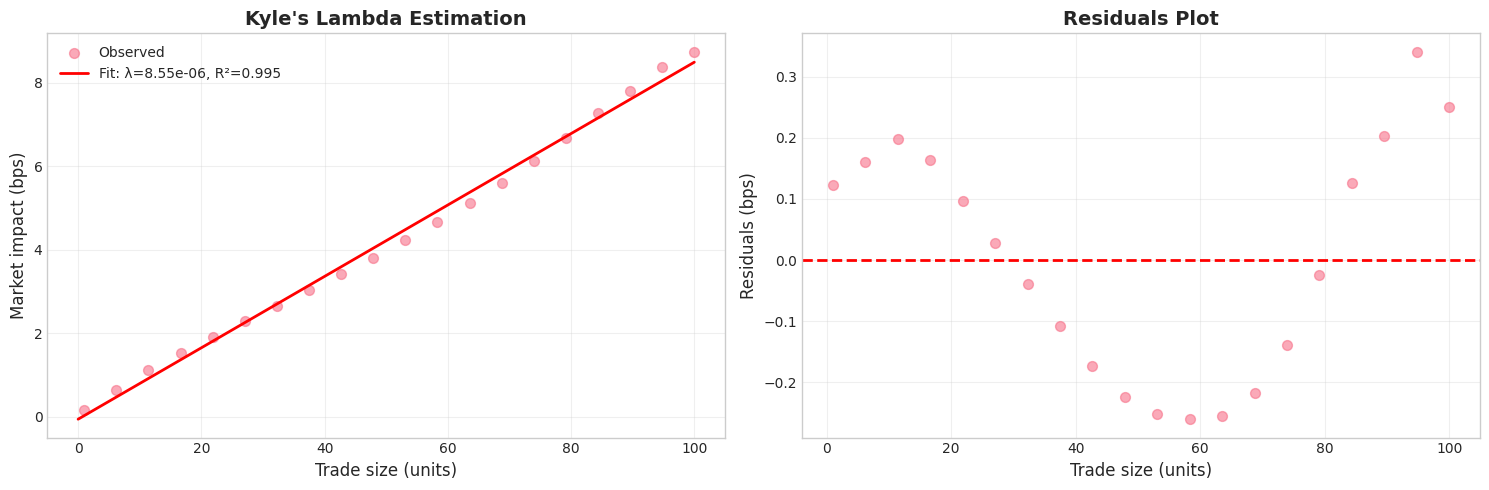

In [5]:
print("📈 Estimating k (Kyle's lambda)...\n")
print("Simulating market orders at different sizes...\n")

# Test different trade sizes
trade_sizes = np.linspace(1, 100, 20)
impact_data = []

# Use first 100 snapshots for speed
for snapshot in snapshots[:min(100, len(snapshots))]:
    bids = np.array(snapshot['bids'], dtype=float)
    asks = np.array(snapshot['asks'], dtype=float)
    
    if len(bids) == 0 or len(asks) == 0:
        continue
    
    mid_price = (bids[0, 0] + asks[0, 0]) / 2
    
    # Simulate buy orders (walk up the ask side)
    for size in trade_sizes:
        remaining = size
        total_cost = 0.0
        
        for price, quantity in asks:
            if remaining <= 0:
                break
            executed = min(remaining, quantity)
            total_cost += executed * price
            remaining -= executed
        
        if remaining <= 0:  # Sufficient liquidity
            avg_price = total_cost / size
            impact = (avg_price - mid_price) / mid_price
            impact_data.append({'size': size, 'impact': impact})

# Create DataFrame and aggregate
df_kyle = pd.DataFrame(impact_data)
df_kyle_grouped = df_kyle.groupby('size')['impact'].mean().reset_index()

print(f"✅ Collected {len(df_kyle)} impact measurements")
print(f"   Samples per size: {len(df_kyle) / len(trade_sizes):.0f}")

# Linear regression: impact = λ × size
slope, intercept, r_value, p_value, std_err = linregress(
    df_kyle_grouped['size'], 
    df_kyle_grouped['impact']
)

k_estimated = slope

print(f"\nRegression results:")
print(f"   Slope (λ):  {k_estimated:.8f}")
print(f"   Intercept:  {intercept:.8f}")
print(f"   R²:         {r_value**2:.4f}")
print(f"   p-value:    {p_value:.6f}")

print(f"\n✅ k = {k_estimated:.8f}")
print(f"   For 100 units: impact ≈ {k_estimated * 100 * 10000:.2f} bps")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Linear plot
ax = axes[0]
ax.scatter(df_kyle_grouped['size'], df_kyle_grouped['impact'] * 10000, 
           alpha=0.6, s=50, label='Observed')
x_line = np.array([0, df_kyle_grouped['size'].max()])
y_line = (k_estimated * x_line + intercept) * 10000
ax.plot(x_line, y_line, 'r-', linewidth=2,
        label=f'Fit: λ={k_estimated:.2e}, R²={r_value**2:.3f}')
ax.set_xlabel('Trade size (units)', fontsize=12)
ax.set_ylabel('Market impact (bps)', fontsize=12)
ax.set_title("Kyle's Lambda Estimation", fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Residuals
ax = axes[1]
residuals = df_kyle_grouped['impact'] - (k_estimated * df_kyle_grouped['size'] + intercept)
ax.scatter(df_kyle_grouped['size'], residuals * 10000, alpha=0.6, s=50)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Trade size (units)', fontsize=12)
ax.set_ylabel('Residuals (bps)', fontsize=12)
ax.set_title('Residuals Plot', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# 3. Estimate η and φ (Temporary Impact)

In [6]:
print("💥 Estimating η and φ (power-law parameters)...\n")

# Test different trade sizes
test_sizes = [1, 2, 5, 10, 20, 50, 100]
impact_data_full = []

print(f"Testing {len(test_sizes)} different trade sizes...\n")

for snapshot in snapshots:
    bids = np.array(snapshot['bids'], dtype=float)
    asks = np.array(snapshot['asks'], dtype=float)
    
    if len(bids) == 0 or len(asks) == 0:
        continue
    
    mid_price = (bids[0, 0] + asks[0, 0]) / 2
    
    for size in test_sizes:
        # Participation rate
        rho = size / DAILY_VOLUME
        
        # Simulate market buy order
        remaining = size
        total_cost = 0.0
        
        for price, quantity in asks:
            if remaining <= 0:
                break
            executed = min(remaining, quantity)
            total_cost += executed * price
            remaining -= executed
        
        if remaining <= 0:  # Sufficient liquidity
            avg_price = total_cost / size
            impact = (avg_price - mid_price) / mid_price
            
            impact_data_full.append({
                'size': size,
                'rho': rho,
                'impact': impact
            })

df_impact = pd.DataFrame(impact_data_full)
df_impact_grouped = df_impact.groupby(['size', 'rho'])['impact'].mean().reset_index()

print(f"✅ Collected {len(df_impact)} impact measurements")
print(f"   Samples per size: {len(df_impact) / len(test_sizes):.0f}\n")

# Non-linear regression: impact = η × ρ^(1+φ) + ψ × ρ
def power_law_impact(rho, eta, phi, psi):
    """Power-law impact function."""
    return eta * np.abs(rho)**(1 + phi) + psi * np.abs(rho)

# Initial guess and bounds
p0 = [0.01, 0.5, psi_estimated]  # [η, φ, ψ]
bounds = ([0, 0.1, 0], [1, 1.5, 0.01])  # Constrain parameters

try:
    # Fit the model
    params, covariance = curve_fit(
        power_law_impact,
        df_impact_grouped['rho'],
        df_impact_grouped['impact'],
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )
    
    eta_estimated, phi_estimated, psi_fitted = params
    perr = np.sqrt(np.diag(covariance))
    
    print(f"✅ Calibration successful!\n")
    print(f"Calibrated parameters:")
    print(f"   η (execution cost):     {eta_estimated:.6f} ± {perr[0]:.6f}")
    print(f"   φ (power exponent):     {phi_estimated:.4f} ± {perr[1]:.4f}")
    print(f"   ψ (fitted, for ref):    {psi_fitted:.6f} ± {perr[2]:.6f}")
    
    # Goodness of fit
    y_pred = power_law_impact(df_impact_grouped['rho'], *params)
    ss_res = np.sum((df_impact_grouped['impact'] - y_pred)**2)
    ss_tot = np.sum((df_impact_grouped['impact'] - df_impact_grouped['impact'].mean())**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    print(f"\nGoodness of fit:")
    print(f"   R² = {r_squared:.4f}")
    
    # Note: Use psi_estimated (from spread) not psi_fitted
    print(f"\n💡 Note: Using ψ from spread ({psi_estimated:.6f}) rather than fitted value")
    
    calibration_success = True
    
except RuntimeError as e:
    print(f"❌ Calibration failed: {e}")
    print(f"   Using default values instead")
    eta_estimated = 0.01
    phi_estimated = 0.5
    r_squared = 0.0
    calibration_success = False

💥 Estimating η and φ (power-law parameters)...

Testing 7 different trade sizes...

✅ Collected 202 impact measurements
   Samples per size: 29

✅ Calibration successful!

Calibrated parameters:
   η (execution cost):     0.833557 ± 2.209948
   φ (power exponent):     0.2354 ± 1.3048
   ψ (fitted, for ref):    0.008729 ± 1.054296

Goodness of fit:
   R² = 0.9886

💡 Note: Using ψ from spread (0.000042) rather than fitted value


---

# Visualization of Calibrated Model

📊 Plot saved to: ../results/impact_calibration.png


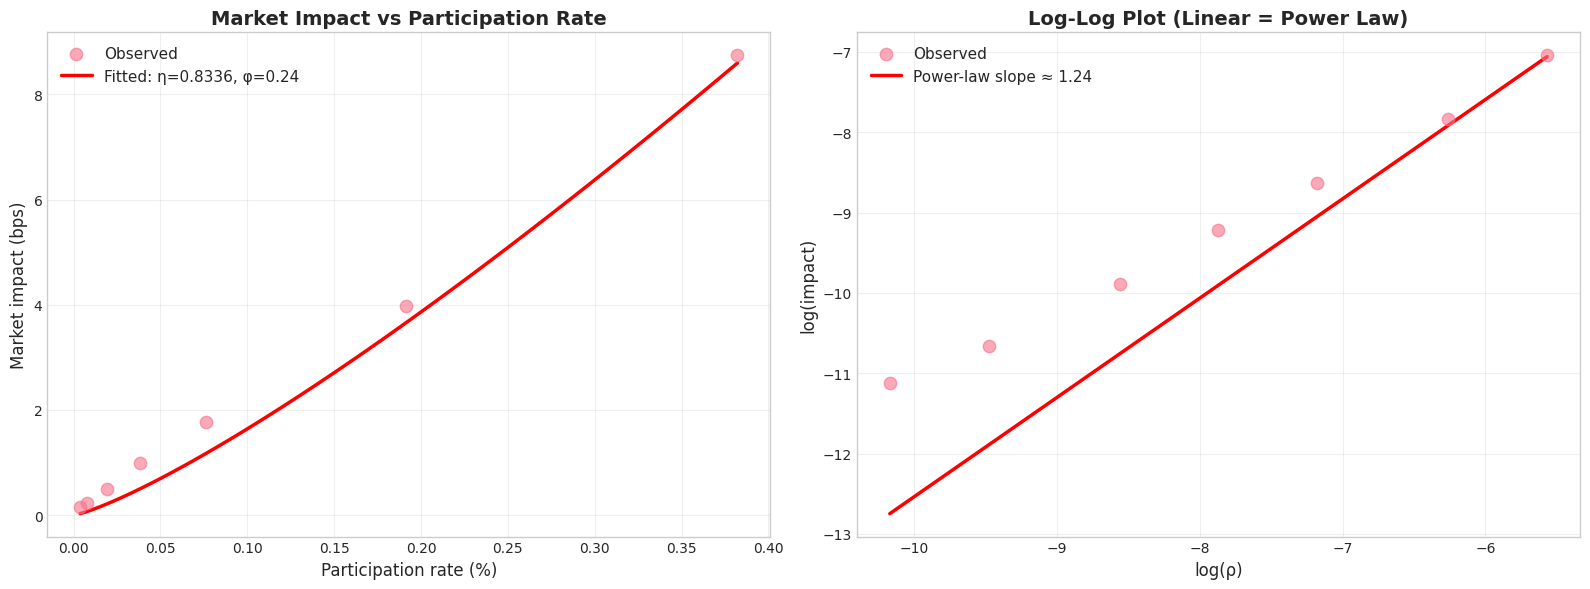

In [7]:
if calibration_success:
    # Generate smooth curves
    rho_smooth = np.linspace(df_impact_grouped['rho'].min(), 
                             df_impact_grouped['rho'].max(), 100)
    impact_smooth = power_law_impact(rho_smooth, eta_estimated, phi_estimated, psi_estimated)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Impact vs participation rate
    ax = axes[0]
    ax.scatter(df_impact_grouped['rho'] * 100, df_impact_grouped['impact'] * 10000,
               alpha=0.6, s=80, label='Observed', zorder=3)
    ax.plot(rho_smooth * 100, impact_smooth * 10000, 'r-', linewidth=2.5,
            label=f'Fitted: η={eta_estimated:.4f}, φ={phi_estimated:.2f}', zorder=2)
    ax.set_xlabel('Participation rate (%)', fontsize=12)
    ax.set_ylabel('Market impact (bps)', fontsize=12)
    ax.set_title('Market Impact vs Participation Rate', fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # 2. Log-log plot (to see power-law)
    ax = axes[1]
    # Filter out zeros for log
    mask = (df_impact_grouped['rho'] > 0) & (df_impact_grouped['impact'] > 0)
    ax.scatter(np.log(df_impact_grouped.loc[mask, 'rho']),
               np.log(df_impact_grouped.loc[mask, 'impact']),
               alpha=0.6, s=80, label='Observed', zorder=3)
    
    mask_smooth = (rho_smooth > 0) & (impact_smooth > 0)
    ax.plot(np.log(rho_smooth[mask_smooth]), np.log(impact_smooth[mask_smooth]),
            'r-', linewidth=2.5, label=f'Power-law slope ≈ {1+phi_estimated:.2f}', zorder=2)
    
    ax.set_xlabel('log(ρ)', fontsize=12)
    ax.set_ylabel('log(impact)', fontsize=12)
    ax.set_title('Log-Log Plot (Linear = Power Law)', fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    os.makedirs('../results', exist_ok=True)
    plt.savefig('../results/impact_calibration.png', dpi=150, bbox_inches='tight')
    print(f"📊 Plot saved to: ../results/impact_calibration.png")
    
    plt.show()
else:
    print("⚠️ Calibration failed, skipping visualization")

---

# Summary & Save Results

In [8]:
print("="*70)
print("CALIBRATION RESULTS")
print("="*70)
print(f"\nSymbol: {SYMBOL}")
print(f"Snapshots used: {len(snapshots)}")
print(f"Daily volume: {DAILY_VOLUME:,.0f} units/day")
print("\n" + "-"*70)
print("CALIBRATED PARAMETERS:")
print("-"*70)
print(f"  k  (permanent impact)    = {k_estimated:.8f}")
print(f"  η  (execution cost)      = {eta_estimated:.6f}")
print(f"  φ  (power exponent)      = {phi_estimated:.4f}")
print(f"  ψ  (proportional costs)  = {psi_estimated:.6f} ({psi_estimated*10000:.2f} bps)")
print("-"*70)
print(f"\nGoodness of fit:")
print(f"  Kyle's lambda R²:  {r_value**2:.4f}")
if calibration_success:
    print(f"  Power-law R²:      {r_squared:.4f}")
print("="*70)

# Compare with literature
print(f"\n📚 Comparison with literature:")
print(f"   φ = {phi_estimated:.2f} vs [0.3-0.7] (Almgren et al. 2005, Kyle & Obizhaeva 2016)")
if 0.3 <= phi_estimated <= 0.7:
    print(f"   ✅ φ is within expected range")
else:
    print(f"   ⚠️ φ is outside typical range - may need more data or different market conditions")

print(f"\n   ψ = {psi_estimated*10000:.2f} bps (typical: 5-30 bps for crypto)")
if 5 <= psi_estimated*10000 <= 30:
    print(f"   ✅ ψ is within expected range")
else:
    print(f"   ⚠️ ψ is outside typical range")

CALIBRATION RESULTS

Symbol: BTCUSDT
Snapshots used: 30
Daily volume: 26,163 units/day

----------------------------------------------------------------------
CALIBRATED PARAMETERS:
----------------------------------------------------------------------
  k  (permanent impact)    = 0.00000855
  η  (execution cost)      = 0.833557
  φ  (power exponent)      = 0.2354
  ψ  (proportional costs)  = 0.000042 (0.42 bps)
----------------------------------------------------------------------

Goodness of fit:
  Kyle's lambda R²:  0.9947
  Power-law R²:      0.9886

📚 Comparison with literature:
   φ = 0.24 vs [0.3-0.7] (Almgren et al. 2005, Kyle & Obizhaeva 2016)
   ⚠️ φ is outside typical range - may need more data or different market conditions

   ψ = 0.42 bps (typical: 5-30 bps for crypto)
   ⚠️ ψ is outside typical range


In [9]:
# Save calibrated parameters
results = {
    'symbol': SYMBOL,
    'timestamp': pd.Timestamp.now().isoformat(),
    'num_snapshots': len(snapshots),
    'daily_volume': DAILY_VOLUME,
    'parameters': {
        'k': k_estimated,
        'eta': eta_estimated,
        'phi': phi_estimated,
        'psi': psi_estimated
    },
    'goodness_of_fit': {
        'kyle_r_squared': r_value**2,
        'powerlaw_r_squared': r_squared if calibration_success else None
    }
}

os.makedirs('../results', exist_ok=True)
output_file = '../results/calibrated_parameters.json'

with open(output_file, 'w') as f:
    json.dump(results, f, indent=2, default=float)

print(f"\n💾 Calibrated parameters saved to:")
print(f"   {output_file}")
print(f"\n🎯 Next step: Use these parameters in notebooks 02 and 03!")


💾 Calibrated parameters saved to:
   ../results/calibrated_parameters.json

🎯 Next step: Use these parameters in notebooks 02 and 03!


---

# How to Use These Parameters

Copy this code snippet into notebooks 02 and 03:

```python
import json

# Load calibrated parameters
with open('results/calibrated_parameters.json', 'r') as f:
    calibrated = json.load(f)

params = calibrated['parameters']

k_calibrated = params['k']
eta_calibrated = params['eta']
phi_calibrated = params['phi']
psi_calibrated = params['psi']

print(f"Using calibrated parameters:")
print(f"  k   = {k_calibrated:.8f}")
print(f"  η   = {eta_calibrated:.6f}")
print(f"  φ   = {phi_calibrated:.4f}")
print(f"  ψ   = {psi_calibrated:.6f}")
```